## Developing Model for Transaction Recovery

Install dependecies

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 6.2 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.8 MB/s eta 0:00:0000:0100:01
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080015 sha256=c481c69eadb55bc238f277f4562b37661ade02fa41e1667c9bf04a974ced834d
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.6.2
    Uninstalling bokeh-3.6.2:
      Successfully uninstalled bokeh-3.6.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not install packages due t

In [2]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

import boto3

from time import gmtime, strftime

import numpy as np

import json 

import matplotlib.pyplot as plt 
import seaborn as sns


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [4]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [201]:
# Identify the categorical columns
categorical_columns = ['country', 'gender', 'subscription_tier'] 
one_hot_encoder = OneHotEncoder(sparse_output=False)
directory = 'data'
files = ['train', 'validate', 'test']

for file_name in files:
    df = pd.read_csv(directory + "/" + file_name + '.csv')
    encoded_features = pd.DataFrame(one_hot_encoder.fit_transform(df[categorical_columns]))
    df = df.drop(categorical_columns, axis=1)
    df = pd.concat([df, encoded_features], axis=1)
    columns = ['failed'] + [col for col in df if col != 'failed']
    df = df[columns]    
    print (df.head())
    df.to_csv(directory + "/" + file_name + '_lr.csv', index=False, header=False)
    if file_name == 'test':
        df = df.drop(df.columns[0], axis=1)
        df.to_csv(directory + "/" + file_name + '_lr_predict.csv', index=False, header=False)



   failed  age  tenure  products_number  credit_card  active_member  amount  \
0       0   41       2                2            1              1  123.55   
1       1   54       4                1            1              0  126.46   
2       0   30       8                2            0              1   93.47   
3       0   50       7                2            1              1  129.06   
4       0   37       6                1            1              0   84.57   

   engagement_score  billing_failure_count    0    1    2    3    4    5    6  \
0              48.0                      1  0.0  1.0  0.0  0.0  1.0  1.0  0.0   
1              26.0                      2  0.0  1.0  0.0  1.0  0.0  0.0  0.0   
2              72.0                      1  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
3              68.0                      5  0.0  0.0  1.0  0.0  1.0  1.0  0.0   
4              34.0                      2  1.0  0.0  0.0  0.0  1.0  1.0  0.0   

     7  
0  0.0  
1  1.0  
2  1.0  
3 

In [202]:
print(df.dtypes)


age                        int64
tenure                     int64
products_number            int64
credit_card                int64
active_member              int64
amount                   float64
engagement_score         float64
billing_failure_count      int64
0                        float64
1                        float64
2                        float64
3                        float64
4                        float64
5                        float64
6                        float64
7                        float64
dtype: object


## Generate train/ test /validate files and  upload data to S3

In [203]:
## Upload to S3
import pandas as pd

# Load the dataset
df = pd.read_csv("data/test_lr.csv", header=None)

# Check for inconsistent rows
# row_lengths = df.apply(lambda x: len(x), axis=1)
# inconsistent_rows = row_lengths[row_lengths != row_lengths.iloc[0]]
print(f"Inconsistent rows:\n{inconsistent_rows}")
print(f"Number of columns: {df.shape[1]}")


Inconsistent rows:
Series([], dtype: int64)
Number of columns: 17


In [204]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = "arn:aws:iam::190647331505:role/saba-sagemaker"

print("AWS role: {}".format(role))
bucket= "saba-transaction-data"
print("Default Bucket: {}".format(bucket))

region = "us-east-1"
print("AWS Region: {}".format(region))

train_path = sagemaker_session.upload_data(path="data/train_lr.csv", bucket=bucket, key_prefix='data')
print("train_path: {}".format(train_path))
test_path = sagemaker_session.upload_data(path="data/test_lr.csv", bucket=bucket, key_prefix='data')
test_predict_path = sagemaker_session.upload_data(path="data/test_lr_predict.csv", bucket=bucket, key_prefix='data')
val_path = sagemaker_session.upload_data(path="data/validate_lr.csv", bucket=bucket, key_prefix='data')

AWS role: arn:aws:iam::190647331505:role/saba-sagemaker
Default Bucket: saba-transaction-data
AWS Region: us-east-1
train_path: s3://saba-transaction-data/data/train_lr.csv


## train Linear Regression

In [205]:
import sagemaker
from sagemaker import image_uris

sagemaker_session = sagemaker.Session()

linear_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uris.retrieve(framework='linear-learner', region=region),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/output',
    sagemaker_session=sagemaker_session, 
    enable_sagemaker_metrics=True, 
    debug_hook_config=True
)

print("created Estimator")
 
# Set hyperparameters for LinearLearner
linear_estimator.set_hyperparameters(
    feature_dim=16,  # Number of features (change this based on your dataset)
    predictor_type='regressor',
    mini_batch_size=100,
    epochs=10 
)
print("set hyperparameters")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


created Estimator
set hyperparameters


In [206]:
from sagemaker.inputs import TrainingInput

train_data = TrainingInput(s3_data=train_path, content_type='text/csv')
validate_data = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
linear_estimator.fit({'train': train_data, 'validation': validate_data})


INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-13-02-21-13-885


2024-12-13 02:21:15 Starting - Starting the training job...
2024-12-13 02:21:30 Starting - Preparing the instances for training...
2024-12-13 02:22:01 Downloading - Downloading input data...
2024-12-13 02:22:41 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/13/2024 02:24:07 INFO 139805544339264] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '0.01', 'huber_delta':

In [207]:
model_name = linear_estimator.latest_training_job.name  # Training job name often serves as model name
print(f"Model Name: {model_name}")

training_job_desc = linear_estimator.latest_training_job.describe()

# Retrieve the S3 URI for the model artifact
model_artifact = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model Artifact S3 URI: {model_artifact}")

# Retrieve the Docker image URI used for the training job
image_uri = training_job_desc["AlgorithmSpecification"]["TrainingImage"]
print(f"Image URI: {image_uri}")

Model Name: linear-learner-2024-12-13-02-21-13-885
Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-21-13-885/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [208]:
#Register model
from sagemaker import Model

# Get the training job name
training_job_name = linear_estimator.latest_training_job.name


# Create the model
model = Model(
    model_data=model_artifact,  
    role=role, # same role as in training
    image_uri=image_uri,
)

# Register the model
model.name = training_job_name
model.create()

print(f"Model {training_job_name} registered successfully!")


INFO:sagemaker:Creating model with name: linear-learner-2024-12-13-02-21-13-885


Model linear-learner-2024-12-13-02-21-13-885 registered successfully!


### Transform train data

In [209]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=training_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://saba-transaction-data/output",
)

transformer.transform(
    data="s3://saba-transaction-data/data/test_lr_predict.csv",  # Test dataset in S3
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()


INFO:sagemaker:Creating transform job with name: linear-learner-2024-12-13-02-26-08-270


.................................Docker entrypoint called with argument(s): serve
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/13/2024 02:32:00 INFO 139764278257472] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Running default environment configuration script
[12/13/2024 02:32:00 INFO 139764278257472] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_

In [214]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the predictions file
predictions_df = pd.read_json('data/test_lr_predict.csv.out', lines=True)

# Load the ground truth file without headers
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)


# Assume the last column in the ground truth file is the target column
target_column = ground_truth_df.columns[0]

# Adjust the threshold (e.g., 30.0)
for threshold in [0.20, 0.25, 0.30, 0.50]:
    predictions_df['predicted_label'] = (predictions_df['score'] > threshold).astype(int)
    
    # Combine predictions with ground truth data
    ground_truth_df['predicted_value'] = predictions_df['predicted_label']
    #print (ground_truth_df)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    precision = precision_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    recall = recall_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    f1 = f1_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    conf_matrix = confusion_matrix(ground_truth_df[target_column], ground_truth_df['predicted_value'])
    
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)


Threshold: 0.2
Accuracy: 0.6184276414621933
Precision: 0.33365570599613154
Recall: 0.8253588516746412
F1-Score: 0.47520661157024796
Confusion Matrix:
[[890 689]
 [ 73 345]]
Threshold: 0.25
Accuracy: 0.7085628442663996
Precision: 0.39238845144356954
Recall: 0.715311004784689
F1-Score: 0.5067796610169492
Confusion Matrix:
[[1116  463]
 [ 119  299]]
Threshold: 0.3
Accuracy: 0.7681522283425137
Precision: 0.45871559633027525
Recall: 0.5980861244019139
F1-Score: 0.5192107995846313
Confusion Matrix:
[[1284  295]
 [ 168  250]]
Threshold: 0.5
Accuracy: 0.8087130696044066
Precision: 0.7045454545454546
Recall: 0.14832535885167464
F1-Score: 0.2450592885375494
Confusion Matrix:
[[1553   26]
 [ 356   62]]


In [216]:
ground_truth_df = pd.read_csv("data/train_lr.csv", header=None)

print(ground_truth_df.dtypes)
print("Train target unique values:", ground_truth_df[16].unique())
ground_truth_df = pd.read_csv("data/validate_lr.csv", header=None)

print(ground_truth_df.dtypes)
print("Train target unique values:", ground_truth_df[16].unique())



0       int64
1       int64
2       int64
3       int64
4       int64
5       int64
6     float64
7     float64
8       int64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
dtype: object
Train target unique values: [0. 1.]
0       int64
1       int64
2       int64
3       int64
4       int64
5       int64
6     float64
7     float64
8       int64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
dtype: object
Train target unique values: [0. 1.]


In [217]:

print("Creating logistic regression estimator")

logistic_estimator = sagemaker.estimator.Estimator(
    image_uri=image_uris.retrieve(framework='linear-learner', region=region),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/output',
    sagemaker_session=sagemaker_session,
    enable_sagemaker_metrics=True, 
    debug_hook_config=True
)

print("Setting hyperparameters for logistic regression")
logistic_estimator.set_hyperparameters(
    feature_dim=16,  # Update based on your dataset's number of features
    predictor_type='binary_classifier',
    mini_batch_size=100,
    epochs=10,
    binary_classifier_model_selection_criteria='cross_entropy_loss'
)


# Define input data channels for training and validation
train_data = TrainingInput(s3_data=train_path, content_type='text/csv')
validate_data = TrainingInput(s3_data=val_path, content_type='text/csv')

# Train the model
print("Starting the training job for logistic regression")
logistic_estimator.fit({'train': train_data, 'validation': validate_data})
print("Training job for logistic regression started")



INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating logistic regression estimator


INFO:sagemaker:Creating training-job with name: linear-learner-2024-12-13-02-55-37-447


Setting hyperparameters for logistic regression
Starting the training job for logistic regression
2024-12-13 02:55:39 Starting - Starting the training job...
2024-12-13 02:55:52 Starting - Preparing the instances for training...
2024-12-13 02:56:19 Downloading - Downloading input data...
2024-12-13 02:57:00 Downloading - Downloading the training image......
2024-12-13 02:58:11 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/13/2024 02:58:15 INFO 139934811080512] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'unifor

In [232]:
model_name = logistic_estimator.latest_training_job.name  # Training job name often serves as model name
print(f"Model Name: {model_name}")

training_job_desc = logistic_estimator.latest_training_job.describe()

# Retrieve the S3 URI for the model artifact
model_artifact = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model Artifact S3 URI: {model_artifact}")

# Retrieve the Docker image URI used for the training job
image_uri = training_job_desc["AlgorithmSpecification"]["TrainingImage"]
print(f"Image URI: {image_uri}")

Model Name: linear-learner-2024-12-13-02-55-37-447
Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-55-37-447/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [233]:
#Register model
from sagemaker import Model

# Get the training job name
training_job_name = logistic_estimator.latest_training_job.name
print(f"Model Artifact S3 URI: {model_artifact}")
print(f"Image URI: {image_uri}")

# Create the model
model = Model(
    model_data=model_artifact,  
    role=role, # same role as in training
    image_uri=image_uri,
)

# Register the model
model.name = training_job_name
model.create()

print(f"Model {training_job_name} registered successfully!")


Model Artifact S3 URI: s3://saba-transaction-data/output/linear-learner-2024-12-13-02-55-37-447/output/model.tar.gz
Image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


INFO:sagemaker:Creating model with name: linear-learner-2024-12-13-02-55-37-447


Model linear-learner-2024-12-13-02-55-37-447 registered successfully!


In [239]:
# Define a transformer 
from sagemaker.transformer import Transformer



transformer = Transformer(
    model_name=training_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://saba-transaction-data/output/classifier",
)
    
transformer.transform(
    data="s3://saba-transaction-data/data/test_lr_predict.csv",  # Test dataset in S3
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()

INFO:sagemaker:Creating transform job with name: linear-learner-2024-12-13-21-13-29-156


..................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[12/13/2024 21:19:27 INFO 140409346328384] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[12/13/2024 21:19:31 WARNING 140409346328384] Loggers have already been setup.
[12/13/2024 21:19:31 INFO 140409346328384] loaded entry point class algorithm.serve.server_config:config_api
[12/13/2024 21:19:31 INFO 140409346328384] loading entry points
[12/13/2024 21:19:31 IN

### Transform train data

In [240]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the predictions file
predictions_df = pd.read_json('data/test_lr_predict.csv-classifier.out', lines=True)

# Load the ground truth file without headers
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)


# Assume the last column in the ground truth file is the target column
target_column = ground_truth_df.columns[0]

# Adjust the threshold (e.g., 30.0)
# predictions_df['predicted_label'] = (predictions_df['score'] > threshold).astype(int)

# Combine predictions with ground truth data
ground_truth_df['predicted_value'] = predictions_df['predicted_label']
#print (ground_truth_df)

# Calculate evaluation metrics
accuracy = accuracy_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
precision = precision_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
recall = recall_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
f1 = f1_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
conf_matrix = confusion_matrix(ground_truth_df[target_column], ground_truth_df['predicted_value'])

print(f"Threshold: {threshold}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


Threshold: 0.5
Accuracy: 0.8167250876314471
Precision: 0.7166666666666667
Recall: 0.20574162679425836
F1-Score: 0.31970260223048325
Confusion Matrix:
[[1545   34]
 [ 332   86]]


### Use AUTOGluon

In [241]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [242]:
print(train.describe())

               age       tenure  products_number  credit_card  active_member  \
count  5989.000000  5989.000000      5989.000000  5989.000000    5989.000000   
mean     38.990816     4.998497         1.530973     0.704124       0.514276   
std      10.565890     2.880351         0.579300     0.456474       0.499838   
min      18.000000     0.000000         1.000000     0.000000       0.000000   
25%      32.000000     3.000000         1.000000     0.000000       0.000000   
50%      37.000000     5.000000         1.000000     1.000000       1.000000   
75%      44.000000     7.000000         2.000000     1.000000       1.000000   
max      92.000000    10.000000         4.000000     1.000000       1.000000   

            amount  engagement_score  billing_failure_count       failed  
count  5989.000000       5989.000000            5989.000000  5989.000000  
mean     76.944635         45.589247               1.439138     0.202204  
std      62.854683         16.345007               1.3

# Train / Validate / Test data from files 

In [254]:
import pandas as pd
from autogluon.tabular import TabularPredictor

# Define column names
num_features = 16
column_names = ['target'] + [f'feature_{i}' for i in range(1, num_features + 1)]

# Load datasets with the new column names
train_data = pd.read_csv('data/train_lr.csv', header=None, names=column_names)
val_data = pd.read_csv('data/validate_lr.csv', header=None, names=column_names)
test_data = pd.read_csv('data/test_lr.csv', header=None, names=column_names)
train_data.head()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16
0,0,41,2,2,1,1,123.55,48.0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,54,4,1,1,0,126.46,26.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,30,8,2,0,1,93.47,72.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,50,7,2,1,1,129.06,68.0,5,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0,37,6,1,1,0,84.57,34.0,2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Define TabularPredictor and run with default settings in local environment 

In [255]:
import pandas as pd
from autogluon.tabular import TabularPredictor


# Define the TabularPredictor with parameters
predictor = TabularPredictor(
    label='target',
    problem_type='binary',
    eval_metric='accuracy'  # You can specify other metrics such as 'roc_auc', 'f1', etc.
).fit(
    train_data,
    hyperparameters={
        'GBM': {},  # LightGBM
        'CAT': {},  # CatBoost
        'NN_TORCH': {},  # Neural network
        'XGB': {},  # XGBoost
        'RF': {},  # Random Forest
        'KNN': {},  # K-Nearest Neighbors
    },
    time_limit=600,  # Specify time limit for training (in seconds)
    presets='best_quality'  # Use predefined set of hyperparameters for best quality
)

# Evaluate on validation data
val_results = predictor.evaluate(val_data)

# Predict and evaluate on test data
test_predictions = predictor.predict(test_data.drop(columns=['target']))
test_results = predictor.evaluate_predictions(y_true=test_data['target'], y_pred=test_predictions)

# Display the results
print("Validation Results:", val_results)
print("Test Results:", test_results)

# Evaluate on validation data
val_results = predictor.evaluate(val_data)

# Predict and evaluate on test data
test_predictions = predictor.predict(test_data.drop(columns=['target']))
test_results = predictor.evaluate_predictions(y_true=test_data['target'], y_pred=test_predictions)

# Display the results
print("Validation Results:", val_results)
print("Test Results:", test_results)


No path specified. Models will be saved in: "AutogluonModels/ag-20241216_202011/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20241216_202011/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Wed Jul 17 10:54:05 UTC 2024
Disk Space Avail:   188.95 GB / 499.96 GB (37.8%)
Train Data Rows:    5989
Train Data Columns: 16
Label Column: target
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Selected class <--> label m

Validation Results: {'accuracy': 0.8607911867801703, 'balanced_accuracy': 0.7030932999373826, 'mcc': 0.5092439203813587, 'roc_auc': 0.8562351283656857, 'f1': 0.5587301587301587, 'precision': 0.7652173913043478, 'recall': 0.44}
Test Results: {'accuracy': 0.8647971957936905, 'balanced_accuracy': 0.7218888158273512, 'mcc': 0.5455419568299371, 'f1': 0.5958083832335329, 'precision': 0.796, 'recall': 0.47607655502392343}


Evaluation: accuracy on test data: 0.8607911867801703
Evaluations on test data:
{
    "accuracy": 0.8607911867801703,
    "balanced_accuracy": 0.7030932999373826,
    "mcc": 0.5092439203813587,
    "roc_auc": 0.8562351283656857,
    "f1": 0.5587301587301587,
    "precision": 0.7652173913043478,
    "recall": 0.44
}
Evaluation: accuracy on test data: 0.8647971957936905
Evaluations on test data:
{
    "accuracy": 0.8647971957936905,
    "balanced_accuracy": 0.7218888158273512,
    "mcc": 0.5455419568299371,
    "f1": 0.5958083832335329,
    "precision": 0.796,
    "recall": 0.47607655502392343
}


Validation Results: {'accuracy': 0.8607911867801703, 'balanced_accuracy': 0.7030932999373826, 'mcc': 0.5092439203813587, 'roc_auc': 0.8562351283656857, 'f1': 0.5587301587301587, 'precision': 0.7652173913043478, 'recall': 0.44}
Test Results: {'accuracy': 0.8647971957936905, 'balanced_accuracy': 0.7218888158273512, 'mcc': 0.5455419568299371, 'f1': 0.5958083832335329, 'precision': 0.796, 'recall': 0.47607655502392343}


## Analyze the results , see the the leaderboard, which includes all models used in the ensemble

In [259]:
from autogluon.tabular import TabularPredictor

# Load the saved model
predictor = TabularPredictor.load("AutogluonModels/ag-20241216_202011/")
# Get the leaderboard, which includes all models used in the ensemble
leaderboard = predictor.leaderboard(silent=True)
leaderboard


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L1,0.869427,0.059275,32.946823,0.059275,32.946823,1,True,4
1,WeightedEnsemble_L2,0.869427,0.080214,35.469826,0.020939,2.523003,2,True,7
2,LightGBM_BAG_L1,0.868759,0.055012,21.828925,0.055012,21.828925,1,True,2
3,XGBoost_BAG_L1,0.867758,0.076837,8.757547,0.076837,8.757547,1,True,5
4,NeuralNetTorch_BAG_L1,0.864752,0.336189,341.030484,0.336189,341.030484,1,True,6
5,RandomForest_BAG_L1,0.858574,0.607803,2.530446,0.607803,2.530446,1,True,3
6,KNeighbors_BAG_L1,0.811655,0.404473,0.217561,0.404473,0.217561,1,True,1


In [1]:
## Display confusion matrix for the best model

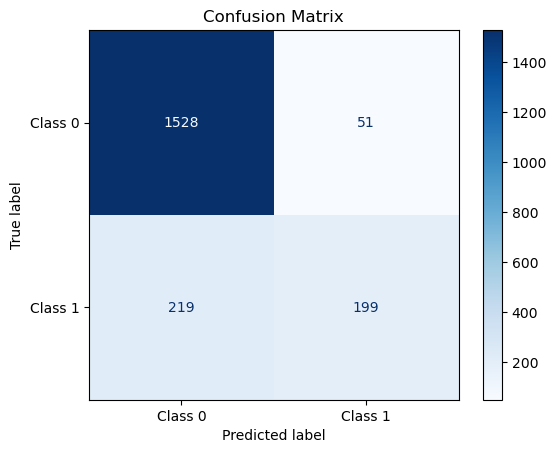

In [261]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Separate features and target
X_test = test_data.drop(columns=['target'])
y_test = test_data['target']
# Make predictions
y_pred = predictor.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Display training metrics in comparison with benchmark result 

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


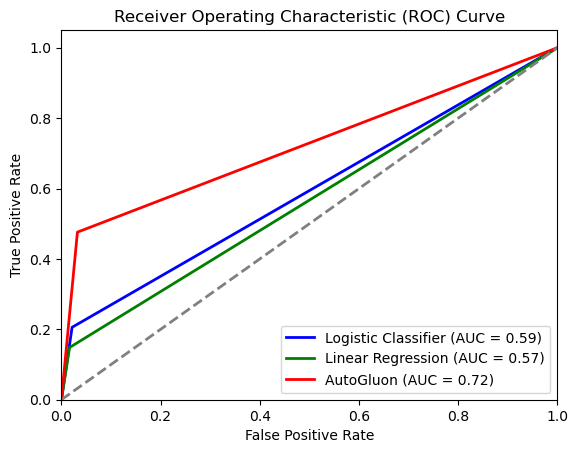

In [289]:
predictions_df = pd.read_json('data/test_lr_predicted_classifier.out', lines=True)
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)
ground_truth_df.head()
target_column = ground_truth_df.columns[0]
y_true = ground_truth_df[target_column]
y_prob_logistic = predictions_df['predicted_label']

#test_data.head()
y_prob_df = predictor.predict(test_data.drop(columns=['target']))
print (y_prob_df.head())
y_prob_autogluon =  y_prob_df[0]

predictions_linear_df = pd.read_json('data/test_lr_predicted_regress.out', lines=True)
y_prob_linear = (predictions_linear_df['score'] > 0.5).astype(int)


# Compute ROC curve and AUC for each model
fpr_logistic, tpr_logistic, _ = roc_curve(y_true, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_linear, tpr_linear, _ = roc_curve(y_true, y_prob_linear)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_autogluon, tpr_autogluon, _ = roc_curve(y_true, y_prob_df)
roc_auc_autogluon = auc(fpr_autogluon, tpr_autogluon)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label=f'Logistic Classifier (AUC = {roc_auc_logistic:.2f})')
plt.plot(fpr_linear, tpr_linear, color='green', lw=2, label=f'Linear Regression (AUC = {roc_auc_linear:.2f})')
plt.plot(fpr_autogluon, tpr_autogluon, color='red', lw=2, label=f'AutoGluon (AUC = {roc_auc_autogluon:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/app/AWS-Machine-Learning-Engineer-Capstone/figures/roc_plot_all.png', format='png', dpi=300, bbox_inches='tight')

plt.show()



##  AutoGluon with optimized hyperparameters 

In [294]:
import pandas as pd
from autogluon.tabular import TabularPredictor

# Define column names
num_features = 16
column_names = ['target'] + [f'feature_{i}' for i in range(1, num_features + 1)]

# Load datasets with the new column names
train_data = pd.read_csv('data/train_lr.csv', header=None, names=column_names)
val_data = pd.read_csv('data/validate_lr.csv', header=None, names=column_names)
test_data = pd.read_csv('data/test_lr.csv', header=None, names=column_names)

from autogluon.tabular import TabularPredictor

# Define more detailed hyperparameters for each model
hyperparameters = {
    'GBM': [
        {'num_leaves': 31, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5},
        {'num_leaves': 50, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 7},
        {'num_leaves': 70, 'learning_rate': 0.05, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 10}
    ],
    'CAT': [
        {'iterations': 500, 'depth': 6, 'learning_rate': 0.01, 'l2_leaf_reg': 3},
        {'iterations': 1000, 'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 5},
        {'iterations': 1500, 'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 4}
    ],
    'XGB': [
        {'n_estimators': 100, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8},
        {'n_estimators': 500, 'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0},
        {'n_estimators': 300, 'max_depth': 4, 'eta': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9}
    ]
}

# Train the model with the specified hyperparameters
predictor_hp = TabularPredictor(
    label='target',
    problem_type='binary',
    eval_metric='accuracy'  # You can specify other metrics such as 'roc_auc', 'f1', etc.
).fit(
    train_data,
    hyperparameters=hyperparameters,
    time_limit=1200,  # Increase the time limit for more extensive tuning
    presets='best_quality'  # Use predefined set of hyperparameters for best quality
)


# Evaluate on validation data
val_results = predictor.evaluate(val_data)

# Predict and evaluate on test data
test_predictions = predictor.predict(test_data.drop(columns=['target']))
test_results = predictor.evaluate_predictions(y_true=test_data['target'], y_pred=test_predictions)

# Display the results
print("Validation Results:", val_results)
print("Test Results:", test_results)

# Evaluate on validation data
val_results = predictor.evaluate(val_data)

# Predict and evaluate on test data
test_predictions = predictor.predict(test_data.drop(columns=['target']))
test_results = predictor.evaluate_predictions(y_true=test_data['target'], y_pred=test_predictions)

# Display the results
print("Validation Results:", val_results)
print("Test Results:", test_results)



No path specified. Models will be saved in: "AutogluonModels/ag-20241216_231130/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20241216_231130/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Wed Jul 17 10:54:05 UTC 2024
Disk Space Avail:   188.75 GB / 499.96 GB (37.8%)
Train Data Rows:    5989
Train Data Columns: 16
Label Column: target
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Selected class <--> label 

[1000]	valid_set's binary_error: 0.139037


	0.8661	 = Validation score   (accuracy)
	108.53s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: LightGBM_2_BAG_L1 ... Training model for up to 477.14s of the 477.13s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8646	 = Validation score   (accuracy)
	54.4s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_3_BAG_L1 ... Training model for up to 464.82s of the 464.81s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8659	 = Validation score   (accuracy)
	92.29s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 431.51s of the 431.5s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8641	 = Validation score   (accuracy)
	140.03s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: CatBoost_2_B

Validation Results: {'accuracy': 0.8607911867801703, 'balanced_accuracy': 0.7030932999373826, 'mcc': 0.5092439203813587, 'roc_auc': 0.8562351283656857, 'f1': 0.5587301587301587, 'precision': 0.7652173913043478, 'recall': 0.44}
Test Results: {'accuracy': 0.8647971957936905, 'balanced_accuracy': 0.7218888158273512, 'mcc': 0.5455419568299371, 'f1': 0.5958083832335329, 'precision': 0.796, 'recall': 0.47607655502392343}


Evaluation: accuracy on test data: 0.8647971957936905
Evaluations on test data:
{
    "accuracy": 0.8647971957936905,
    "balanced_accuracy": 0.7218888158273512,
    "mcc": 0.5455419568299371,
    "f1": 0.5958083832335329,
    "precision": 0.796,
    "recall": 0.47607655502392343
}


Validation Results: {'accuracy': 0.8607911867801703, 'balanced_accuracy': 0.7030932999373826, 'mcc': 0.5092439203813587, 'roc_auc': 0.8562351283656857, 'f1': 0.5587301587301587, 'precision': 0.7652173913043478, 'recall': 0.44}
Test Results: {'accuracy': 0.8647971957936905, 'balanced_accuracy': 0.7218888158273512, 'mcc': 0.5455419568299371, 'f1': 0.5958083832335329, 'precision': 0.796, 'recall': 0.47607655502392343}


### Modify the training job to include only models that have big impact 

In [297]:
import pandas as pd
from autogluon.tabular import TabularPredictor


# Define the TabularPredictor with parameters
predictor = TabularPredictor(
    label='target',
    problem_type='binary',
    eval_metric='accuracy'  # You can specify other metrics such as 'roc_auc', 'f1', etc.
).fit(
    train_data,
    hyperparameters={
        'GBM': {},  # LightGBM
        'XGB': {},  # XGBoost
        'RF': {},  # Random Forest
    },
    time_limit=600,  # Specify time limit for training (in seconds)
    presets='best_quality'  # Use predefined set of hyperparameters for best quality
)

# Evaluate on validation data
val_results = predictor.evaluate(val_data)

# Predict and evaluate on test data
test_predictions = predictor.predict(test_data.drop(columns=['target']))
test_results = predictor.evaluate_predictions(y_true=test_data['target'], y_pred=test_predictions)

# Display the results
print("Validation Results:", val_results)
print("Test Results:", test_results)


No path specified. Models will be saved in: "AutogluonModels/ag-20241217_001431/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20241217_001431/"
AutoGluon Version:  0.8.3
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Wed Jul 17 10:54:05 UTC 2024
Disk Space Avail:   187.27 GB / 499.96 GB (37.5%)
Train Data Rows:    5989
Train Data Columns: 16
Label Column: target
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Selected class <--> label m

Validation Results: {'accuracy': 0.8592889334001002, 'balanced_accuracy': 0.7040278647463996, 'mcc': 0.504976801223199, 'roc_auc': 0.8535629304946775, 'f1': 0.5588697017268446, 'precision': 0.7510548523206751, 'recall': 0.445}
Test Results: {'accuracy': 0.8673009514271407, 'balanced_accuracy': 0.7296287093460521, 'mcc': 0.556109889396892, 'f1': 0.6085672082717873, 'precision': 0.7953667953667953, 'recall': 0.49282296650717705}


### Analyze model 

In [298]:
from autogluon.tabular import TabularPredictor

# Load the saved model
predictor = TabularPredictor.load("AutogluonModels/ag-20241217_001431/")
# Get the leaderboard, which includes all models used in the ensemble
leaderboard = predictor.leaderboard(silent=True)
leaderboard


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.866422,3.218043,545.642133,0.022518,2.142504,2,True,4
1,XGBoost_BAG_L1,0.865420,1.784115,267.647043,1.784115,267.647043,1,True,3
2,LightGBM_BAG_L1,0.863416,1.021495,270.150666,1.021495,270.150666,1,True,1
3,RandomForest_BAG_L1,0.858574,0.389914,5.701921,0.389914,5.701921,1,True,2


## Train and evaluate XGBoost model as the highest performer in AutoGluon

In [305]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data
categorical_columns = ['country', 'gender', 'subscription_tier'] 
one_hot_encoder = OneHotEncoder(sparse_output=False)
df = pd.read_csv('data/cleaned_file.csv')
encoded_features = pd.DataFrame(one_hot_encoder.fit_transform(df[categorical_columns]))
df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_features], axis=1)
# columns = ['failed'] + [col for col in df if col != 'failed']
# df = df[columns]    
print (df.head())


# Define the label column
label = 'failed'  # Replace with your actual target column name

# Shuffle and split the data
X = df.drop(columns=[label])
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



   age  tenure  products_number  credit_card  active_member  amount  \
0   42       2                1            1              1    1.00   
1   41       1                1            0              1   84.81   
2   42       8                3            1              0  160.66   
3   39       1                2            0              0    1.00   
4   43       2                1            1              1  126.51   

   engagement_score  billing_failure_count  failed    0    1    2    3    4  \
0              38.0                      2       1  1.0  0.0  0.0  1.0  0.0   
1              34.0                      0       0  0.0  0.0  1.0  1.0  0.0   
2              62.0                      2       1  1.0  0.0  0.0  1.0  0.0   
3              24.0                      1       0  1.0  0.0  0.0  1.0  0.0   
4              38.0                      0       0  0.0  0.0  1.0  1.0  0.0   

     5    6    7  
0  0.0  0.0  1.0  
1  0.0  0.0  1.0  
2  0.0  0.0  1.0  
3  0.0  0.0  1.0  
4  

In [306]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=500, 
    max_depth=10, 
    learning_rate=0.01, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(report)


Accuracy: 0.8668002003004507
ROC AUC: 0.8572868438250753
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1586
           1       0.80      0.47      0.59       411

    accuracy                           0.87      1997
   macro avg       0.84      0.72      0.76      1997
weighted avg       0.86      0.87      0.85      1997



## Since XGBoost performs so well, we decided to fine tune the model

In [309]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

param_grid = { 'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.01, 0.1], 'subsample': [0.8, 0.9], 'colsample_bytree': [0.8, 1.0] }

# Create the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, enable_categorical=False)

# Use GridSearchCV or RandomizedSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(report)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.8632607062359129
Accuracy: 0.871807711567351
ROC AUC: 0.8640599159924275
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1586
           1       0.80      0.50      0.62       411

    accuracy                           0.87      1997
   macro avg       0.84      0.73      0.77      1997
weighted avg       0.87      0.87      0.86      1997



## ROC diagram

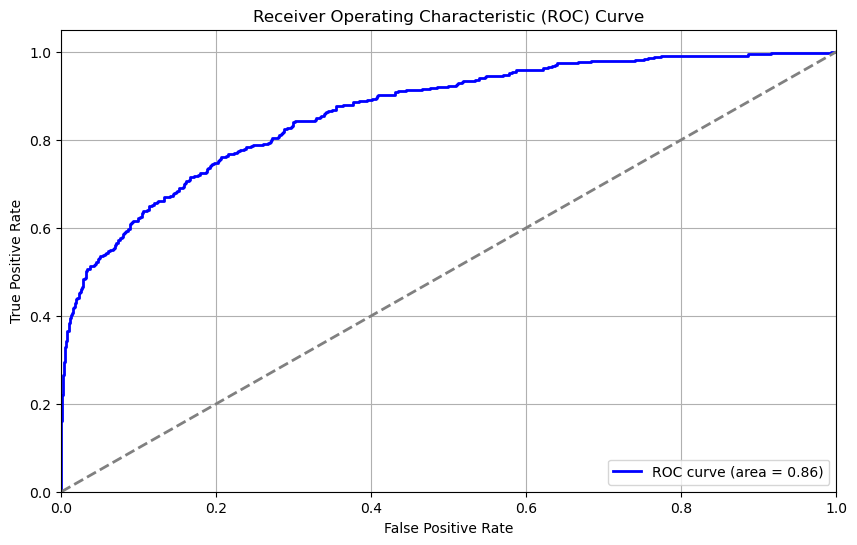

In [313]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have the true labels and predicted probabilities
y_true = y_test  # True labels
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Predicted probabilities

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### add on the diagram the previous code for model 7 (XGBoost) and AutoGluon model 6

      age  tenure  products_number  credit_card  active_member  amount  \
1254   46       3                2            1              1    1.00   
8255   38       8                2            1              0    1.00   
1662   52       4                1            0              1    1.00   
7463   31       1                1            0              0  157.11   
6532   45       3                1            0              1  105.12   

      engagement_score  billing_failure_count    0    1    2    3    4    5  \
1254              52.0                      1  0.0  0.0  1.0  0.0  1.0  1.0   
8255              52.0                      1  1.0  0.0  0.0  0.0  1.0  0.0   
1662              46.0                      0  1.0  0.0  0.0  0.0  1.0  0.0   
7463              14.0                      2  1.0  0.0  0.0  0.0  1.0  0.0   
6532              42.0                      0  1.0  0.0  0.0  1.0  0.0  0.0   

        6    7  
1254  0.0  0.0  
8255  0.0  1.0  
1662  1.0  0.0  
7463  1.0  0

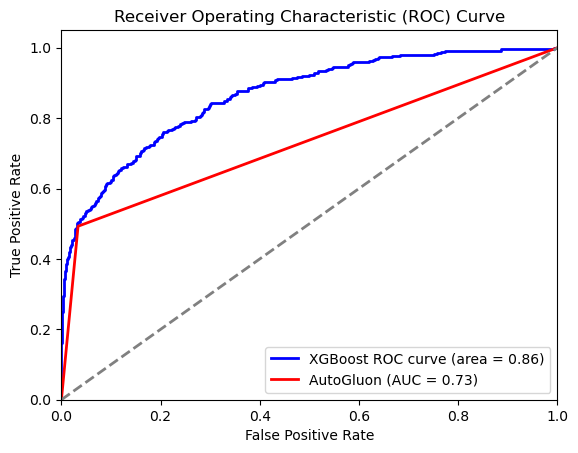

In [321]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# True labels
y_true = y_test

# Predicted probabilities for XGBoost
y_prob_xgb = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_true, y_prob_xgb)
roc_auc_xgb = roc_auc_score(y_true, y_prob_xgb)
print (X_test.head())

# Predicted probabilities for AutoGluon
target_column = ground_truth_df.columns[0]
fpr_autogluon, tpr_autogluon, _ = roc_curve(ground_truth_df[target_column] , y_prob_df)
roc_auc_autogluon = auc(fpr_autogluon, tpr_autogluon)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_autogluon, tpr_autogluon, color='red', lw=2, label=f'AutoGluon (AUC = {roc_auc_autogluon:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/app/AWS-Machine-Learning-Engineer-Capstone/figures/roc_plot_autogl_xgboost.png', format='png', dpi=300, bbox_inches='tight')

plt.show()



# plt.figure(figsize=(10, 6))
# plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:.2f})')
# plt.plot(fpr_ag, tpr_ag, color='green', lw=2, label=f'AutoGluon ROC curve (area = {roc_auc_ag:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curves')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


## We will  retrain XGBoost with the best parameters in SageMaker and deploy endpoint 

AWS role: arn:aws:iam::190647331505:role/saba-sagemaker
Default Bucket: saba-transaction-data
AWS Region: us-east-1
train_path: s3://saba-transaction-data/data/train_lr.csv


## XGBoost model requires target column to be the last column, 
we need to rearrange columns in the files we used for linear learner models

In [49]:
import pandas as pd

df = pd.read_csv('data/train_lr.csv', header=None)
df = pd.concat([df.iloc[:, 1:], df.iloc[:, 0]], axis=1)
df.to_csv('data/train_xdb.csv', index=False, header=False)


if labels.isin([0, 1]).all(): 
    print("All labels are valid (0 or 1).") 
else: 
    print("Found invalid labels in the dataset.")

print (len(df.columns))

df = pd.read_csv('data/validate_lr.csv', header=None)
df = pd.concat([df.iloc[:, 1:], df.iloc[:, 0]], axis=1)
df.to_csv('data/validate_xdb.csv', index=False, header=False)

if labels.isin([0, 1]).all(): 
    print("All labels are valid (0 or 1).") 
else: 
    print("Found invalid labels in the dataset.")

print (len(df.columns))

df = pd.read_csv('data/test_lr.csv', header=None)
df = pd.concat([df.iloc[:, 1:], df.iloc[:, 0]], axis=1)
df.to_csv('data/test_xdb.csv', index=False, header=False)

print(df.iloc[:, -1])



All labels are valid (0 or 1).
17
All labels are valid (0 or 1).
17
0       0
1       0
2       0
3       0
4       0
       ..
1992    0
1993    0
1994    1
1995    0
1996    0
Name: 0, Length: 1997, dtype: int64


In [65]:
import sagemaker
from sagemaker import image_uris

sagemaker_session = sagemaker.Session()
role = "arn:aws:iam::190647331505:role/saba-sagemaker"
print("AWS role: {}".format(role))
bucket= "saba-transaction-data"
print("Default Bucket: {}".format(bucket))

region = "us-east-1"
print("AWS Region: {}".format(region))

s3_input_train = sagemaker_session.upload_data(path="data/train_lr.csv", bucket=bucket, key_prefix='data')
print("train_path: {}".format(train_path))
test_path = sagemaker_session.upload_data(path="data/test_lr.csv", bucket=bucket, key_prefix='data')
test_predict_path = sagemaker_session.upload_data(path="data/test_lr_predict.csv", bucket=bucket, key_prefix='data')
s3_input_validation = sagemaker_session.upload_data(path="data/validate_lr.csv", bucket=bucket, key_prefix='data')

AWS role: arn:aws:iam::190647331505:role/saba-sagemaker
Default Bucket: saba-transaction-data
AWS Region: us-east-1
train_path: s3://saba-transaction-data/data/train_xdb.csv


In [66]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()


print("train_data: {}".format(s3_input_train))
print("validate_data: {}".format(s3_input_validation))

# Prepare data (assuming you have your data in an S3 bucket)
# Launch the tuning job
train_data = TrainingInput(s3_data=s3_input_train, content_type='text/csv')
validate_data = TrainingInput(s3_data=s3_input_validation, content_type='text/csv')



train_data: s3://saba-transaction-data/data/train_lr.csv
validate_data: s3://saba-transaction-data/data/validate_lr.csv


In [67]:
from sagemaker.estimator import Estimator

# Define the image URI for the built-in XGBoost algorithm
image_uri = sagemaker.image_uris.retrieve("xgboost", region=session.boto_region_name, version="1.3-1")

# Initialize the XGBoost estimator with a larger instance type
xgb_estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.4xlarge',  # Larger instance type for faster training
    hyperparameters={
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'colsample_bytree': 0.8,
        'eta': 0.1,
        'max_depth': 5,
        'n_estimators': 100,
        'subsample': 0.8
    },
    output_path=f's3://{bucket}/output'
)


In [ ]:
# Define the hyperparameter search space
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter
from sagemaker.inputs import TrainingInput


hyperparameter_ranges = {
    'colsample_bytree': ContinuousParameter(0.6, 1.0),
    'eta': ContinuousParameter(0.01, 0.2),
    'max_depth': IntegerParameter(3, 7),
    'subsample': ContinuousParameter(0.6, 1.0)
}

# Initialize the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name = 'binary:logistic',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=2
)

# Launch the tuning job
train_data = TrainingInput(s3_data=s3_input_train, content_type='text/csv')
validate_data = TrainingInput(s3_data=s3_input_validation, content_type='text/csv')

tuner.fit({'train': train_data, 'validation': validate_data})


In [77]:
import boto3
from sagemaker.tuner import HyperparameterTuningJobAnalytics

# Initialize the SageMaker client
sm_client = boto3.client('sagemaker')

# Replace with your tuning job name
tuning_job_name = 'XGBoost-tuning'

# Get tuning job analytics
tuning_job_analytics = HyperparameterTuningJobAnalytics(tuning_job_name)

# Get the best training job
best_training_job = tuning_job_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False).iloc[0]

# Print the best training job details
print(best_training_job)


colsample_bytree                                 0.800401
eta                                              0.112352
max_depth                                             4.0
num_round                                           429.0
subsample                                        0.787507
TrainingJobName               XGBoost-tuning-182-5d808c29
TrainingJobStatus                               Completed
FinalObjectiveValue                               0.85524
TrainingStartTime               2024-12-20 02:08:08+00:00
TrainingEndTime                 2024-12-20 02:08:37+00:00
TrainingElapsedTimeSeconds                           29.0
TrainingJobDefinitionName                         xgboost
Name: 111, dtype: object


In [78]:
import boto3
import pandas as pd
from sagemaker import Model
from sagemaker.transformer import Transformer


sm_client = boto3.client('sagemaker')

training_job_name = "XGBoost-tuning-182-5d808c29"
training_job_desc = sm_client.describe_training_job(TrainingJobName=training_job_name)
model_artifact = training_job_desc["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model Artifact S3 URI: {model_artifact}")
image_uri = training_job_desc["AlgorithmSpecification"]["TrainingImage"]
print(f"Image URI: {image_uri}")


# Create the model
model = Model(
    model_data=model_artifact,  
    role=role, # same role as in training
    image_uri=image_uri,
)

# Register the model
model.name = training_job_name
model.create()

print(f"Model {training_job_name} registered successfully!")



INFO:sagemaker:Creating model with name: XGBoost-tuning-182-5d808c29


Model Artifact S3 URI: s3://saba-transaction-data/output/XGBoost-tuning-182-5d808c29/output/model.tar.gz
Image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1
Model XGBoost-tuning-182-5d808c29 registered successfully!


In [80]:

transformer = Transformer(
    model_name=training_job_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path="s3://saba-transaction-data/output/agboost",
)
    
transformer.transform(
    data="s3://saba-transaction-data/data/test_xgb_predict.csv",  # Test dataset in S3
    content_type="text/csv",
    split_type="Line",
)

transformer.wait()


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-12-20-04-19-29-791


............................[2024-12-20:04:24:21:INFO] No GPUs detected (normal if no gpus installed)
[2024-12-20:04:24:21:INFO] No GPUs detected (normal if no gpus installed)
[2024-12-20:04:24:21:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
[2024-12-20:04:24:21:INFO] No GPUs detected (normal if no gpus installed)
[2024-12-20:04:24:21:INFO] No GPUs detected (normal if no gpus installed)
[2024-12-20:04:24:21:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;

In [100]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the predictions file
predictions_df = pd.read_csv('data/test_xgb_predict.csv.out', header=None)
print (predictions_df.columns[0])

# Load the ground truth file without headers
ground_truth_df = pd.read_csv("data/test_lr.csv", header=None)

# Assume the last column in the ground truth file is the target column
target_column = ground_truth_df.columns[0]

# Adjust the threshold (e.g., 0.5)

threshold = 0.45
#ground_truth_df['predicted_value'] = (predictions_df.columns[0] > threshold).astype(int)
ground_truth_df['predicted_value'] = (predictions_df.iloc[:, 0]  > threshold).astype(int)
# Combine predictions with ground truth data
#ground_truth_df['predicted_value'] = predictions_df
print (ground_truth_df)

# Calculate evaluation metrics
accuracy = accuracy_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
precision = precision_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
recall = recall_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
f1 = f1_score(ground_truth_df[target_column], ground_truth_df['predicted_value'])
conf_matrix = confusion_matrix(ground_truth_df[target_column], ground_truth_df['predicted_value'])

print(f"Threshold: {threshold}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


0
      0   1  2  3  4  5       6     7  8    9   10   11   12   13   14   15  \
0     0  26  1  2  0  0    1.00  24.0  2  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
1     0  40  1  1  0  1  174.43  34.0  3  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
2     0  33  8  1  1  1    1.00  62.0  3  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
3     0  37  9  2  1  1    1.00  76.0  2  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
4     0  44  9  2  0  0    1.00  56.0  3  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
...  ..  .. .. .. .. ..     ...   ... ..  ...  ...  ...  ...  ...  ...  ...   
1992  0  23  8  2  1  0   74.31  52.0  1  0.0  1.0  0.0  0.0  1.0  1.0  0.0   
1993  0  67  6  1  1  1  152.86  54.0  0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
1994  1  54  6  1  1  1  172.14  54.0  1  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
1995  0  31  7  1  1  1  137.66  58.0  4  1.0  0.0  0.0  0.0  1.0  0.0  1.0   
1996  0  31  6  2  1  1    1.00  64.0  0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   

       16  predicted_value  
0     1.0           

### Endpoint configuration 1 `transaction-predict` was created manually using the best performing model `XGBoost-tuning-182-5d808c29` . Now we deploy it as endpoint

In [101]:
import boto3

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Parameters
endpoint_name = "transaction-predict-1"  # Provide a unique name for the new endpoint
endpoint_config_name = "transaction-predict"  # Replace with your endpoint config name

# Create the endpoint
response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

print(f"Endpoint creation started: {response['EndpointArn']}")

Endpoint creation started: arn:aws:sagemaker:us-east-1:190647331505:endpoint/transaction-predict-1


### Envoke endpoint programmatically: 

In [106]:
import boto3

sagemaker_runtime = boto3.client('sagemaker-runtime')

with open('data/test_xgb_predict.csv', 'r') as file:
    first_line = file.readline().strip()  # Read the first line and strip newline characters

# Invoke endpoint with the first line as input
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',  # CSV format
    Body=first_line
)
print(first_line)
# Parse and print the response
result = response['Body'].read().decode('utf-8')
print(f"Prediction result: {result}")


26,1,2,0,0,1.0,24.000000000000004,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
Prediction result: 0.015935370698571205



In [104]:
import boto3
# Read the last 6 lines from the CSV file
with open('data/test_xgb_predict.csv', 'r') as file:
    lines = file.readlines()[-6:]  # Get the last 6 lines
    last_six_lines = ''.join([line.strip() + '\n' for line in lines]).strip()  # Ensure formatting
# Invoke endpoint with the last 6 lines as input
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',  # CSV format
    Body=last_six_lines
)

# Parse and print the response
result = response['Body'].read().decode('utf-8')
print(f"Prediction result:\n{result}")


Prediction result:
0.8344537019729614
0.04135052114725113
0.09537344425916672
0.24276868999004364
0.03896211460232735
0.02040906809270382



### Create lambda function that envokes best performing model in AWS console 


### Now invoke created lambda programmatically 

In [108]:
import boto3
import json

lambda_client = boto3.client('lambda')

def invoke_lambda_function(function_name, payload):
    try:
        # Convert the payload to JSON format if it's not already a string
        payload = json.dumps(payload)

        # Invoke the Lambda function
        response = lambda_client.invoke(
            FunctionName=function_name,  # Lambda function name or ARN
            InvocationType='RequestResponse',  # 'RequestResponse' for synchronous invocation
            Payload=payload  # The data to pass to the Lambda function
        )

        # Read the response
        response_payload = json.loads(response['Payload'].read().decode())
        print("Lambda function response:", response_payload)
        return response_payload

    except Exception as e:
        print(f"Error invoking Lambda function: {str(e)}")
        return None

# Example usage
lambda_function_name = "predict-transaction"  # Replace with your Lambda function name
input_data = {
  "input_data": "26,1,2,0,0,1.0,24.000000000000004,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0"
}
response  = invoke_lambda_function(lambda_function_name, input_data)
print (response)


Lambda function response: {'statusCode': 200, 'body': '{"prediction": "0.015935370698571205\\n"}'}
{'statusCode': 200, 'body': '{"prediction": "0.015935370698571205\\n"}'}


### Finaly we create REST API and call lambda with POST request


curl -X POST https://isx8ecrvxb.execute-api.us-east-1.amazonaws.com/demo/transaction-predict      -H "Content-Type: application/json"      -d '{"input_data": "26,1,2,0,0,1.0,24.000000000000004,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0"}'
{"statusCode": 200, "body": "{\"prediction\": \"0.015935370698571205\\n\"}"}